In [1]:
import os
os.chdir('..')
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

from baseline import build_base_dataset
from m5.metric import WRMSSE
from m5.constants import *
from utils.funcs import only_days_columns
from baseline import window_stats

In [3]:
ds = build_base_dataset()

[2020-06-21 10:55:39,964] INFO: Use cache


In [4]:
metric = WRMSSE(ds[ds['d'] < 1914], ds[ds['d'] >= 1914])

[2020-06-21 10:56:30,912] INFO: Calculate profit
[2020-06-21 10:56:49,051] INFO: Transform train to standard view
[2020-06-21 10:58:25,892] INFO: Transform validation to standard view
[2020-06-21 10:58:26,481] INFO: Calculate levels specification
100%|██████████| 12/12 [00:54<00:00,  4.58s/it]


In [5]:
# затираем реальные продажи и цену, дабы не ликнуть данные
ds.loc[:, 'target_sold'] = ds.loc[:, 'sold']
ds.loc[:, 'target_price'] = ds.loc[:, 'sell_price']

ds.loc[ds['d'] >= 1914, 'sold'] = np.nan
ds.loc[ds['d'] >= 1914, 'sell_price'] = np.nan

ds['sold'] = ds['sold'].astype(np.float32)
ds['sell_price'] = ds['sell_price'].astype(np.float32)
ds['target_sold'] = ds['target_sold'].astype(np.float16)
ds['target_price'] = ds['target_price'].astype(np.float16)

# Подготовка набора данных

## Статистика по группам

In [13]:
ds_stat_features = window_stats(
    ds,
    features=['sold', 'sell_price'],
    stat_funcs=['mean', 'std'],
    levels=[
        'id',
        'item_id',
        ['state_id', 'item_id'],
        ['state_id', 'dept_id'],
        ['store_id', 'item_id'],
        ['store_id', 'dept_id'],
    ],
    use_cache=True
)
ds_stat_features = ds_stat_features.drop(ID_COLUMNS, axis=1)
stats_feature = list(set(ds_stat_features.columns.tolist()).difference(ds.columns))

ds = pd.concat([ds, ds_stat_features], axis=1)

## Исключение данных "до старта продаж"

In [14]:
# определяем стартпродаж по критерию - как только был продана хотяб 1 единца - старт т наступил
ds['start_of_sales'] = ds.groupby('id')['sold'].transform(lambda x: np.argmax(x > 0))
# поскольку сдвиг агрегатов у нас минимум 28 дней, то сдвинем старт продаж на этот срок
ds = ds[ds['d'] > (ds['start_of_sales'])]

In [15]:
# выделим часть данных, в которых сверхбольшое количество покупок
ds['use_for_train'] = ds['target_sold'] < 100

## Лаги

In [16]:
ds['sold_shift_28'] = ds.groupby('id')['sold'].transform(lambda x: x.shift(28)).astype(np.float16)
ds['sold_shift_182'] = ds.groupby('id')['sold'].transform(lambda x: x.shift(182)).astype(np.float16)
ds['sold_shift_364'] = ds.groupby('id')['sold'].transform(lambda x: x.shift(364)).astype(np.float16)

In [17]:
ds['price_shift_28'] = ds.groupby('id')['sell_price'].transform(lambda x: x.shift(28)).astype(np.float16)
ds['price_shift_182'] = ds.groupby('id')['sell_price'].transform(lambda x: x.shift(182)).astype(np.float16)
ds['price_shift_364'] = ds.groupby('id')['sell_price'].transform(lambda x: x.shift(364)).astype(np.float16)

# Обучение модели

In [37]:
ds['event_type_1'] = ds['event_type_1'].cat.add_categories('NaN').fillna('NaN')
ds['event_type_2'] = ds['event_type_2'].cat.add_categories('NaN').fillna('NaN')

In [39]:
CATEGORICAL_FEATURES = [
    'dept_id', 'cat_id', 'store_id', 'state_id',
    'weekday', 'month', 'year',
    'event_type_1', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI'
]
NUMERICAL_FEATURES = [
    'sold_shift_28', 'sold_shift_182', 'sold_shift_364',
    'price_shift_28', 'price_shift_182', 'price_shift_364',
] + stats_feature

XS = CATEGORICAL_FEATURES + NUMERICAL_FEATURES
TARGET = 'target_sold'

In [40]:
train_ds = ds[(ds['d'] < 1914) & (ds['use_for_train'])]
val_ds = ds[ds['d'] >= 1914]
# объекты для обучения
train_without_nan = train_ds[XS + [TARGET]].dropna()
val_without_nan = val_ds[XS + [TARGET]].dropna()

In [41]:
train_without_nan.shape, val_without_nan.shape

((34871763, 91), (842319, 91))

In [42]:
train_set = lgb.Dataset(train_without_nan[XS], train_without_nan[TARGET])
valid_set = lgb.Dataset(val_without_nan[XS], val_without_nan[TARGET])

In [55]:
params = {
    'objective': 'poisson', 
    'num_iterations': 2000,
    'learning_rate': 0.1,
    'verbose': 20,
'    bagging_fraction': 0.5,
    'feature_fraction': 0.7
}

In [56]:
model = lgb.train(
    params,
    train_set=train_set,
    valid_sets=[train_set, valid_set],
    early_stopping_rounds=10,
    categorical_feature=CATEGORICAL_FEATURES,
    verbose_eval=20 
)

Training until validation scores don't improve for 10 rounds
[20]	training's poisson: -0.162838	valid_1's poisson: -0.0679806
[40]	training's poisson: -0.284811	valid_1's poisson: -0.166359
[60]	training's poisson: -0.315129	valid_1's poisson: -0.184533
[80]	training's poisson: -0.326466	valid_1's poisson: -0.188906
[100]	training's poisson: -0.332288	valid_1's poisson: -0.191022
[120]	training's poisson: -0.336464	valid_1's poisson: -0.193108
[140]	training's poisson: -0.339428	valid_1's poisson: -0.193501
[160]	training's poisson: -0.342101	valid_1's poisson: -0.195222
[180]	training's poisson: -0.344365	valid_1's poisson: -0.19623
[200]	training's poisson: -0.346306	valid_1's poisson: -0.197157
[220]	training's poisson: -0.348215	valid_1's poisson: -0.198529
[240]	training's poisson: -0.349768	valid_1's poisson: -0.199189
[260]	training's poisson: -0.351128	valid_1's poisson: -0.19984
[280]	training's poisson: -0.352513	valid_1's poisson: -0.200393
[300]	training's poisson: -0.35377

In [59]:
import seaborn as sns

In [60]:
feature_importances = pd.DataFrame(
    sorted(
        sorted(zip(model.feature_importance(importance_type='gain'), model.feature_name()))
    ),
    columns=['values', 'names']
)
feature_importances = feature_importances.sort_values(by='values', ascending=False)

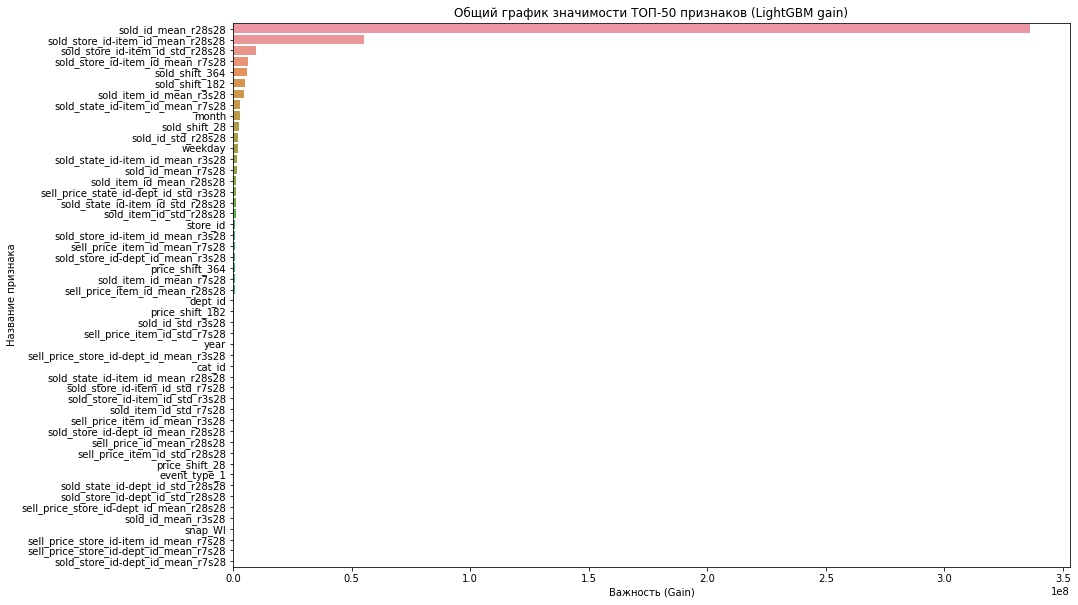

In [61]:
plt.figure(figsize=(15, 10))
sns.barplot(x='values', y='names', data=feature_importances.head(50))
plt.title('Общий график значимости ТОП-50 признаков (LightGBM gain)')
plt.ylabel('Название признака')
plt.xlabel('Важность (Gain)')
plt.show()

# Подготовка "станартного" вида валидации

In [58]:
val_pred = val_ds.copy()
val_pred['sold_predict'] =model.predict(val_ds[XS])
val_pred['d'] = val_pred.d.apply(lambda x: f'd_{x}')
val_pred = val_pred.pivot(index='id', columns='d', values='sold_predict')
val_pred = val_ds[ID_COLUMNS].drop_duplicates().merge(val_pred, on='id')
print('WRMSSE: ', metric.score(val_pred))

WRMSSE:  0.6479813031238341


# Отправка сабмита

In [ ]:
submit_days = only_days_columns(val_pred)
submit_evaluation = val_pred[['id'] + submit_days]
submit_rename_dict = {
    col: f'F{i}' 
    for i, col in enumerate(only_days_columns(submit_evaluation), start=1)
}
submit_evaluation = submit_evaluation.rename(columns=submit_rename_dict)

submit_validation = submit_evaluation.copy()
submit_validation['id'] = submit_validation.id.str.replace('evaluation', 'validation')

submit = pd.concat([submit_evaluation, submit_validation])

In [ ]:
submit.to_csv('submit.csv', index=False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f submit.csv -m "First actual without leak"